In [1]:
from src.Game import Game
from src.Players.Minesweeper_bot import Minesweeper_bot
from src.UI.GUI_Bot_Inputs import GUI_Bot_Inputs
from src.UI.No_UI import No_UI
from src.Grid import Grid

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from tqdm.notebook import tqdm
import numpy as np
from scipy.stats import beta as beta_law
import matplotlib.pyplot as plt

import torch
from random import sample
from importlib import reload

from models.Game_Tensor_Interface import Game_Tensor_Interface

In [2]:
grid_size = 8
mine_percent = 0.15

# Uniform sampling

In [4]:
#Uniform sampling

n_game = 10000
sample_per_game = 3
sample_last = True

tensor_list = []
mines_list =[]
tensor_interface = Game_Tensor_Interface()

for i in tqdm(range(n_game)):
    # Grid initialisation
    grid = Grid(grid_size, grid_size, mine_percent)
    game = Game(grid)
    bot = Minesweeper_bot()
    game.action(*bot.action(*game.visible_grid()))

    visible_grid_list = []
    while not game.is_ended():
        # Register every grids
        visible_grid = game.visible_grid()
        visible_grid_list.append(visible_grid)

        # Play the game
        game.action(*bot.action(*visible_grid))

    if len(visible_grid_list) <= sample_per_game:
        selection = visible_grid_list
    elif sample_last:
        selection = sample(visible_grid_list[:-1], sample_per_game-1)
        selection.append(visible_grid_list[-1])
    else:
        selection = sample(visible_grid_list, sample_per_game)

    for grid_values, grid_view in selection:
        tensor_list.append(tensor_interface.to_tensor(grid_values, grid_view))
        mines_list.append(grid.mines)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
mines_tensor = torch.tensor(mines_list)

C:\Users\toine\AppData\Local\Temp\ipykernel_12232\465619920.py:1: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  mines_tensor = torch.tensor(mines_list)
C:\Users\toine\AppData\Local\Temp\ipykernel_12232\465619920.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  mines_tensor = torch.tensor(mines_list)


In [10]:
data = torch.stack(tensor_list).type(torch.uint8)

In [12]:
data.shape

torch.Size([29868, 10, 8, 8])

In [13]:
mines_tensor.shape

torch.Size([29868, 8, 8])

In [14]:
torch.save([data, mines_tensor], 'dataset/uniform_bot/8x8_2990.pt')

# Losing position sampling

In [5]:
grid_size = 12
mine_percent = 0.22

In [7]:
n_game = 10

def gather_data(n_game:int):
    tensor_list = []
    mines_list =[]
    tensor_interface = Game_Tensor_Interface()

    for i in tqdm(range(n_game)):
        # Grid initialisation
        grid = Grid(grid_size, grid_size, mine_percent)
        game = Game(grid)
        bot = Minesweeper_bot()
        game.action(*bot.action(*game.visible_grid()))

        # Play until we are about to do a mistake (or we win)
        next_action = bot.action(*game.visible_grid())
        while not grid.mines[*next_action] and not game.is_ended():
            game.action(*next_action)
            if not game.is_ended():
                next_action = bot.action(*game.visible_grid())
        
        if grid.mines[*next_action]:
            tensor_list.append(tensor_interface.to_tensor(*game.visible_grid()))
            mines_list.append(grid.mines)

    data = torch.stack(tensor_list).type(torch.uint8)
    mines_tensor = torch.tensor(mines_list)
    return data, mines_tensor


In [8]:
all_res = [gather_data(x) for x in [10]*5]

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\toine\AppData\Local\Temp\ipykernel_8264\4046932697.py:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  mines_tensor = torch.tensor(mines_list)
C:\Users\toine\AppData\Local\Temp\ipykernel_8264\4046932697.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  mines_tensor = torch.tensor(mines_list)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
tensor_representations = torch.cat([x for x, y in all_res])
mines_tensors = torch.tensor(np.concatenate([y for x, y in all_res]))

# Dataset analysis

In [12]:
import Lightning.Tensor_Dir_Dataset as tdt
reload(tdt)

data_model = tdt.Tensor_Dir_Dataset(100)
data_model.prepare_data()

In [4]:
dir_paths = data_model.get_data_folders()

all_datasets = data_model.load_all_datasets(dir_paths)

In [5]:
[len(d) for d in all_datasets]

[143897, 6918, 7498, 8426, 8762, 9102, 19192, 9852, 9891, 9967]

In [6]:
min([len(d) for d in all_datasets])

6918

In [7]:
mine_percents = [d.split('_m')[-1] for d in dir_paths]

(0.0, 12000.0)

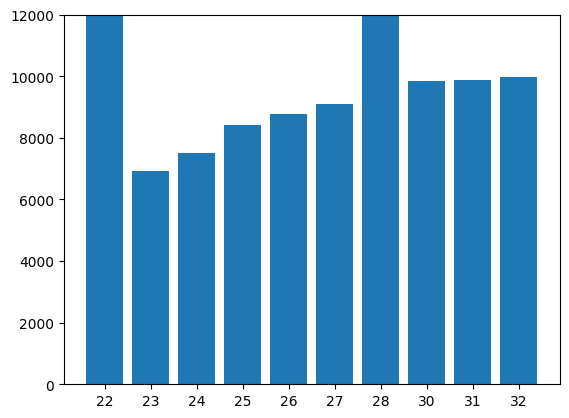

In [8]:
plt.bar(mine_percents, [len(d) for d in all_datasets])
plt.ylim(0, 12000)

In [9]:
from os import listdir
from statsmodels.stats.proportion import proportion_confint


total_run = [len(listdir(d))*1000 for d in dir_paths]
faillure_run = [len(d) for d in all_datasets]
success_run = [t-f for t, f in zip(total_run, faillure_run)]

success_proba = [s/t for s, t in zip(success_run, total_run)]
conf_intervals = [proportion_confint(s, t, alpha=0.05, method='wilson') for s, t in zip(success_run, total_run)]

<ErrorbarContainer object of 3 artists>

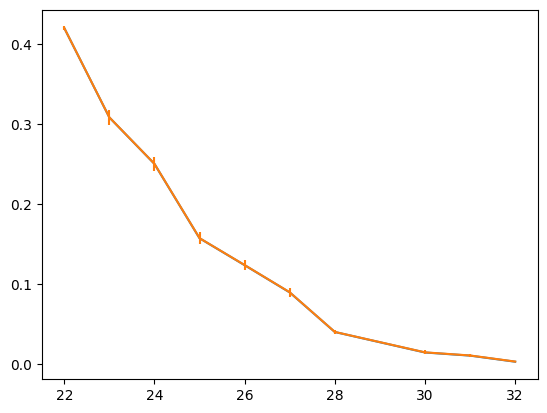

In [10]:
plt.plot([float(m) for m in mine_percents], success_proba)
plt.errorbar([float(m) for m in mine_percents], [(a+b)/2 for a, b in conf_intervals], [(b-a)/2 for a, b in conf_intervals])

In [111]:
import torch.nn.functional as F


grid_tensor, mines = next(iter(data_model.train_dataloader()))

no_mines_proba = torch.rand_like(grid_tensor[:, 0]) # Shape : (100, 12, 12) float

# Remove the possibility to pick a non boundary box by giving it negative probability
boundary = Game_Tensor_Interface.unknown_boundaries(grid_tensor)
no_mines_proba -= (~boundary) * 1

# Remove the probability of picking a discovered box by giving it zero probability
no_mines_proba -= 2*(1-grid_tensor[:, 9])

# Compute max along the two axis of the image
max_return = torch.max(no_mines_proba, dim=-1, keepdim=False)
max_return_2 = torch.max(max_return.values, dim=-1, keepdim=False)

# Retireve 2D indices of max values
i1 = max_return_2.indices
i2 = torch.gather(max_return.indices, -1, i1.view(-1, 1)).view(-1)
i = torch.cat([i1.view(-1, 1), i2.view(-1, 1)], dim=-1)

# Compute the total number of errors
errors = torch.sum(torch.tensor([m[*idx] for m, idx in zip(mines, i)], dtype=torch.float64))

In [112]:
import torch
import torch.nn.functional as F

# Retrieve a batch from the dataloader
grid_tensor, mines = next(iter(data_model.train_dataloader()))

# Random probabilities for no mine (same shape as one grid)
no_mines_proba = torch.rand_like(grid_tensor[:, 0])  # Shape: (batch_size, height, width)

# Mask out non-boundary boxes by setting their probability to -1
boundary_mask = Game_Tensor_Interface.unknown_boundaries(grid_tensor)
no_mines_proba = no_mines_proba.masked_fill(~boundary_mask, -1)

# Mask out discovered boxes by setting their probability to -2
discovered_mask = grid_tensor[:, 9] == 0  # discovered cells have value 1, so this is inverted
no_mines_proba = no_mines_proba.masked_fill(discovered_mask, -2)

# Get 2D indices of the maximum probabilities for each grid in the batch
max_vals, max_indices_row = torch.max(no_mines_proba, dim=-1)  # max along width
max_vals, max_indices_col = torch.max(max_vals, dim=-1)        # max along height

# Combine row and column indices into 2D coordinates
max_indices = torch.stack([max_indices_col, 
                           torch.gather(max_indices_row, 1, max_indices_col.unsqueeze(1)).squeeze(-1)], dim=-1)

# Compute the total number of errors by checking the mine at the predicted max indices
# Use advanced indexing instead of loops
predicted_mine_status = mines[torch.arange(mines.size(0)), max_indices[:, 0], max_indices[:, 1]]

# The error is when we predict a cell without a mine, but there's actually a mine
errors = predicted_mine_status.float().sum()

print(f"Total errors: {errors.item()}")


Total errors: 52.0


In [113]:
torch.max(no_mines_proba[0]), no_mines_proba[0, *max_indices[0]]

(tensor(0.9981), tensor(0.9981))

In [94]:
g1 = torch.gather(no_mines_proba, dim=0, index=i1.view(-1, 1, 1))
# g2 = 

In [101]:
torch.index_select(no_mines_proba, dim=1, index=i1).shape

torch.Size([100, 100, 12])

In [95]:
no_mines_proba.shape

torch.Size([100, 12, 12])

In [96]:
i1.shape

torch.Size([100])

In [97]:
g1.shape

torch.Size([100, 1, 1])

In [98]:
no_mines_proba[0, *i[0]]

tensor(0.9950)

In [78]:
torch.max(no_mines_proba[0])

tensor(0.9950)

In [57]:
no_mines_proba.shape

torch.Size([100, 12, 12])

In [58]:
i1.shape

torch.Size([100])

In [60]:
max_return.indices.shape

torch.Size([100, 12])

In [52]:
max_return.indices

tensor([[ 7,  5, 11,  ...,  2,  5,  7],
        [10,  3, 10,  ...,  7,  5,  8],
        [ 3,  3,  9,  ..., 11,  7,  3],
        ...,
        [ 4,  3,  0,  ...,  2, 10,  7],
        [ 3,  3,  8,  ...,  9,  9,  6],
        [10,  7,  8,  ...,  4, 10, 10]])

In [51]:
max_return.indices.shape

torch.Size([100, 12])

In [40]:
no_mines_proba.shape

torch.Size([100, 12, 12])

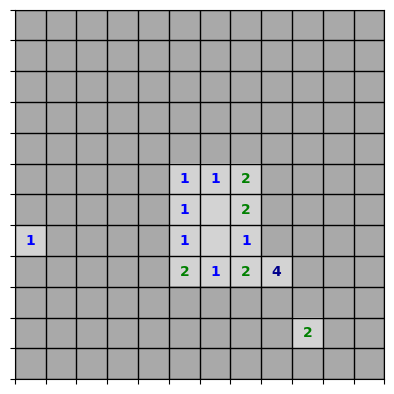

In [34]:
Game_Tensor_Interface.view_grid_tensor(grid_tensor[0])
pass

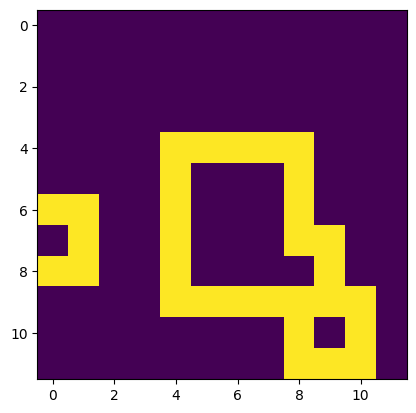

In [35]:
plt.imshow(boundaries[0][0]*1.0)